<center>

# **Analyse de la Danse de l'Égyptien**
</center>

### I. INSTALLATION ET UTILISATION DE LA LIBRAIRIE

Afin de garantir la fiabilité de nos futures analyses de trajectoires, nous mettons en place un test avec l'outil MMPoseInferencer. L'objectif est de vérifier la fiabilité de la lecture et la visualisation des données.

Nous ciblons ici l'extraction des articulations standards (épaules, coudes, poignets) qui seront les variables importante pour la suite de notre projet.

In [5]:
import mmengine
import mmcv
import mmdet
import mmpose
import torch
from mmpose.apis import MMPoseInferencer
import matplotlib.pyplot as plt
import os

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-body7_pt-body7_420e-256x192-e48f03d0_20230504.pth
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth
12/29 10:31:51 - mmengine - INFO - the output image has been saved at vis_results/visualizations/demo.jpg


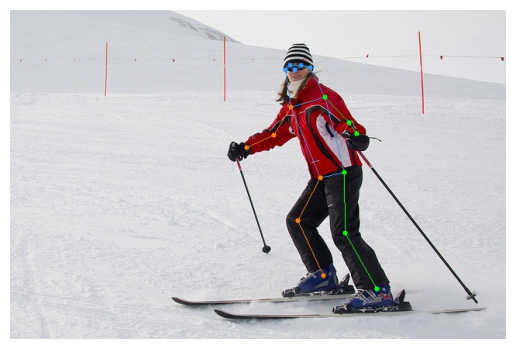

In [8]:
inferencer = MMPoseInferencer('human', device='cpu') 

image = 'demo.jpg'
result_generator = inferencer(image, vis=True, out_dir='vis_results')
result = next(result_generator)

vis_img_path = os.path.join('vis_results', 'visualizations', os.path.basename(image))
vis_img = mmcv.imread(vis_img_path)

plt.imshow(mmcv.bgr2rgb(vis_img))
plt.axis('off')
plt.show()

On remarque bien ici les articulations du corps avec les yeux, les oreilles et le nez. Nous pouvons donc passer à la suite du projet.

### II. PRÉSENTATION DES DONNÉES UTILISÉES

Nous avons choisi de travailler sur une vidéo du jeu Just Dance. Nous avons donc deux vidéos à analyser :
- La vidéo originale de la danse 
- Une vidéo de nous qui reproduisons cette même danse

Notre but est de comparer nos mouvements par rapport à la vidéo originale pour savoir qui de nous reproduit le mieux la danse.
Nous avons choisi un mouvement assez répétitif afin de pouvoir en tirer une prédiction sur les prochains mouvements.

Nous n'avons pas encore filmé la vidéo de nous qui dansons. Pour l'instant nous allons baser nos analyse sur la vidéo originale et nous rajouterons la semaine prochaine notre vidéo.

In [20]:
# Nous avons pris un extrait raw de just dance afin d'éviter le bruit sur la vidéo

from IPython.display import HTML

HTML("""
<video width="600" controls>
  <source src="original.mp4" type="video/mp4">
</video>
""")

### PREMIERS RÉSULTATS

Utilisons MMPoseInferencer afin d'extraire les keypoints de nos vidéos.

In [22]:
original = 'original.mp4'

result_generator = inferencer(original, vis=True, out_dir='vis_results')

for frame_result in result_generator:
    pass

12/29 11:20:48 - mmengine - INFO - the output video has been saved at vis_results/visualizations/original.mp4


L'outil nous génère deux fichiers : 
- Un fichier vidéo mp4 qui reprend la vidéo de base en ajoutant les keypoints directement sur l'image
- Un fichier json qui contient toutes les coordonnées de chaque keypoints image par image et personnes par personnes

C'est sur ce dernier fichier json que nous allons pouvoir étudier les trajectoires et mouvements de nos personnages.

In [23]:
from IPython.display import HTML

HTML(""" 
<video width="600" controls>
  <source src="vis_results/visualizations/original.mp4" type="video/mp4">
</video>
""")

### III. ANALYSE DES TRAJECTOIRES

Nous allons utiliser le fichier json pour extraire la positions des poignets du danseur frame par frame. Cependant, les coordonnées brutes extraites par MMPose sont exprimées en pixels. Nous ne pouvons donc pas travailler directement avec ces valeurs car :
- Un danseur proche de l'objectif aura des mouvements qui paraissent "plus grands" qu'un danseur au second plan.
- La taille des membres varie d'un individu à l'autre.

Pour l'instant cela ne pose pas de problème car nous avons qu'une seule vidéo à analyser mais quand nous ajouterons l'analyse de notre danse, nous aurons besoin de données normalisées.

Nous déplaçons donc l'origine du repère au milieu de la ligne des épaules. Ainsi, la position du poignet est mesurée relativement au buste et non au cadre de l'image.

Nous utilisons la distance euclidienne entre l'épaule gauche et l'épaule droite comme unité de mesure "1".

La formule appliquée pour chaque frame est :

$$Y_{norm} = \frac{Y_{poignet} - Y_{milieu\_épaules}}{Distance(Épaule_{G}, Épaule_{D})}$$

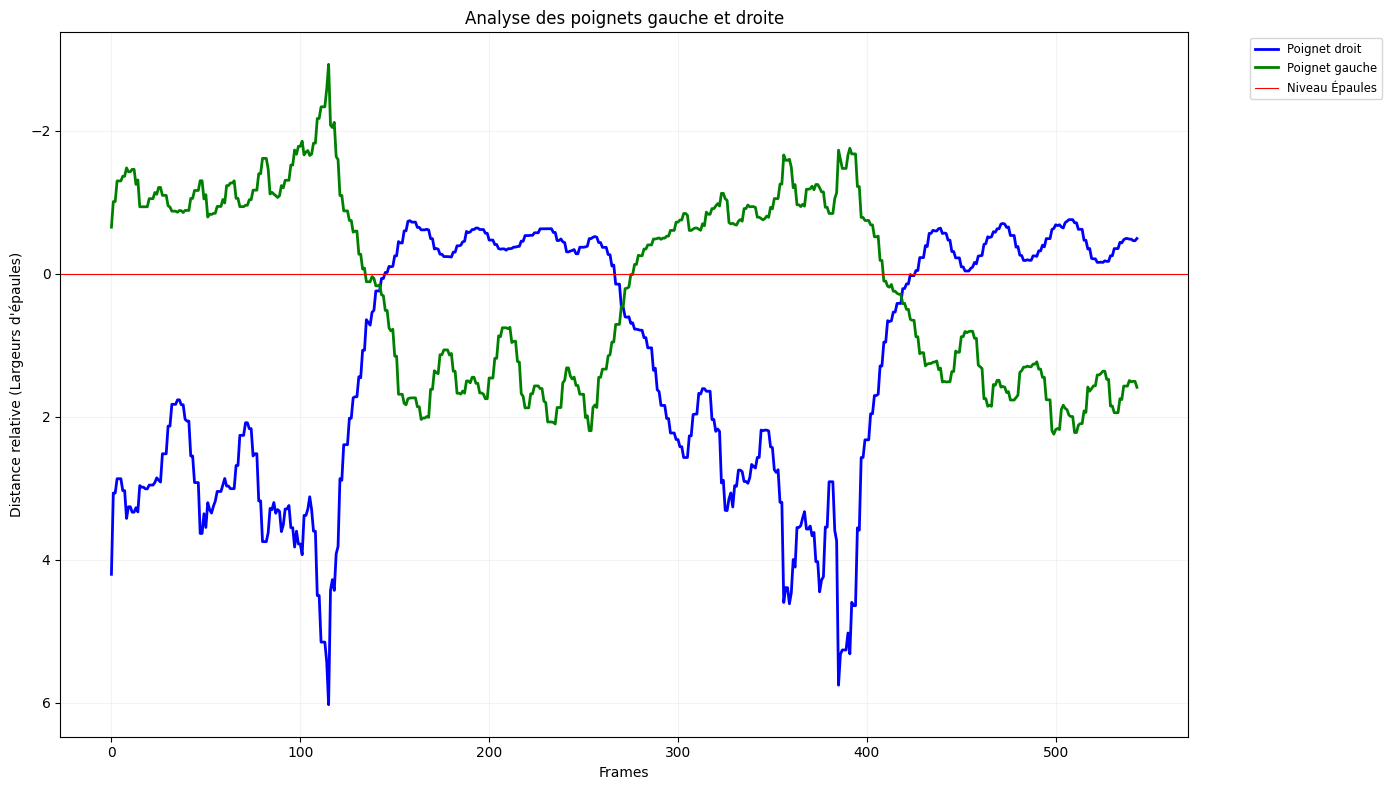

In [39]:
def trajectoires_normalisees(nom_fichier, nb_danseurs=1):
    with open(nom_fichier, 'r') as f:
        data = json.load(f)
    
    frames = []
    # On prépare des listes pour stocker les poignets droits et gauches
    traj_droit = [[] for _ in range(nb_danseurs)]
    traj_gauche = [[] for _ in range(nb_danseurs)]
    
    for f_data in data:
        frames.append(f_data['frame_id'])
        # Tri des personnes de gauche à droite pour ne pas mélanger les courbes
        insts = sorted(f_data['instances'], key=lambda x: np.mean([kp[0] for kp in x['keypoints']]))
        
        for i in range(nb_danseurs):
            if i < len(insts):
                keypoints = np.array(insts[i]['keypoints'])
                
                # 1. Calcul du milieu des épaules (référence 0)
                milieu_epaules = (keypoints[5][1] + keypoints[6][1]) / 2
                
                # 2. Calcul de la largeur des épaules (unité de normalisation)
                largeur_epaules = np.linalg.norm(np.array(keypoints[5][:2]) - np.array(keypoints[6][:2]))
                largeur_epaules = largeur_epaules if largeur_epaules > 0 else 1
                
                # 3. Calcul de la position relative (Y_poignet - Y_épaules) / Largeur_Épaules
                traj_droit[i].append((keypoints[10][1] - milieu_epaules) / largeur_epaules)
                traj_gauche[i].append((keypoints[9][1] - milieu_epaules) / largeur_epaules)
            else:
                traj_droit[i].append(None)
                traj_gauche[i].append(None)
                
    return frames, traj_droit, traj_gauche


frames, poignet_droit, poignet_gauche = trajectoires_normalisees('vis_results/predictions/original.json', nb_danseurs=1)

plt.figure(figsize=(14, 8))
plt.plot(frames, poignet_droit[0], color='blue', linewidth=2, label='Poignet droit')
plt.plot(frames, poignet_gauche[0], color='green', linewidth=2, label='Poignet gauche')
plt.axhline(0, color='red', linestyle='-', linewidth=0.8, label='Niveau Épaules')
plt.title("Analyse des poignets gauche et droite")
plt.xlabel("Frames")
plt.ylabel("Distance relative (Largeurs d'épaules)")
plt.gca().invert_yaxis() 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True, alpha=0.15)
plt.tight_layout()

plt.show()